In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone "https://github.com/maria-natale/ProgettoFVAB"

Cloning into 'ProgettoFVAB'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 275 (delta 108), reused 150 (delta 36), pack-reused 0
Receiving objects: 100% (275/275), 1.65 MiB | 21.72 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [10]:
!python "/content/ProgettoFVAB/Code/create_dataset_2Lan.py"

100% 113/113 [00:53<00:00,  2.10it/s]
100% 40/40 [00:09<00:00,  4.42it/s]
100% 34/34 [00:03<00:00, 10.60it/s]


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
filename = ''
path_drive2 = '/content/drive/MyDrive/Casillo&Natale/dataset/DatasetDueLingue'
dataset_dir = ''
LANGUAGES = {
  1:'Italiano',
  2:'Inglese',
  3: 'Tedesco',
  4:'Spagnolo',
  5: 'Olandese',
  6:'Russo',
  7: 'Giapponese'}

combinations = []
lang = list(LANGUAGES.keys())
for i in range(len(lang)):
  for j in range(i+1, len(lang)):
    combinations.append((i+1, j+1))

# Caricamento dei dati

In [ ]:
# load dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import os

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header= None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    loaded = list()
    for name in filenames:
        data = read_csv(prefix+name)
        data = scaler.fit_transform(data)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix= ''):
    filepath = path_drive2+'/'+dataset_dir+'/features/'
    os.chdir(os.path.join(filepath, group))
    filenames = []
    filenames = [group+'/feature'+str(i)+'.csv' for i in range(0,66)]
    # load input data
    X= load_group(filenames, filepath)
    #load y 
    os.chdir(os.path.join(path_drive2, dataset_dir, 'csv'))
    y = read_csv(filename+'_'+group.split('_')[0]+'_targets_1.csv')
    # load class output
    return X,y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix='', LANGUAGES_N = {}):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    # load all test
    testX, testy = load_dataset_group('test', prefix)
    validationX, validationy = load_dataset_group('validation', prefix)
    trainy['language'] = trainy['language'].map(LANGUAGES_N)
    testy['language'] = testy['language'].map(LANGUAGES_N)
    validationy['language'] = validationy['language'].map(LANGUAGES_N)
    trainy = to_categorical(trainy, len(LANGUAGES_N))
    testy = to_categorical(testy, len(LANGUAGES_N))
    validationy = to_categorical(validationy, len(LANGUAGES_N))
    print(trainX.shape, trainy.shape, testX.shape, testy.shape, validationX.shape, validationy.shape)
    return trainX, trainy, testX, testy, validationX, validationy

# Definizione del modello

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

verbose, epochs, batch_size = 0, 100, 64
def create_model():
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], len(LANGUAGES_N.keys())
    # Initialising the RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (n_timesteps, n_features))))
    model.add(Dropout(0.5))

    # Adding a second LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
    model.add(Dropout(0.5))

    # Adding a third LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(Dropout(0.5))

    # Adding the output layer
    model.add(Dense(n_outputs, activation='softmax'))
    
    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy']
    )

    return model
    

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

with tf.device('/device:GPU:0'):
  for combination in combinations[8:9]: 
    dataset_dir = 'dataset_'+str(combination[0])+'_'+str(combination[1])
    filename=str(combination[0])+'_'+str(combination[1])
    LANGUAGES_N = {
        combination[0]: 0,
        combination[1]: 1
    }
    trainX, trainy, testX, testy, validationX, validationy = load_dataset(path_drive2+'/'+dataset_dir, LANGUAGES_N)
    tf.random.set_seed(42)
    model = create_model()
    history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose, validation_data = (validationX, validationy)) 
    model.evaluate(testX, testy)
    predictions = model.predict_classes(testX) 
    
    LAN = {
        combination[0]: LANGUAGES[combination[0]],
        combination[1]: LANGUAGES[combination[1]]
    }
   
    testy = np.argmax(testy, axis=1)
    target_names = list(LAN.keys())
    report = classification_report(testy, predictions, output_dict=True, target_names=target_names)
    df = pd.DataFrame(report).transpose()
    print (df)
    #df.to_csv('/content/drive/MyDrive/Casillo&Natale/dataset/Risultati/risultati'+filename+'.csv')

    

(183, 350, 66) (183, 2) (57, 350, 66) (57, 2) (59, 350, 66) (59, 2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


2/2 [==============================] - 0s 34ms/step - loss: 0.2698 - accuracy: 0.9474


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score    support
2              0.950000  0.904762  0.926829  21.000000
5              0.945946  0.972222  0.958904  36.000000
accuracy       0.947368  0.947368  0.947368   0.947368
macro avg      0.947973  0.938492  0.942867  57.000000
weighted avg   0.947440  0.947368  0.947087  57.000000


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])


[[[35  1]
  [ 2 19]]

 [[19  2]
  [ 1 35]]]


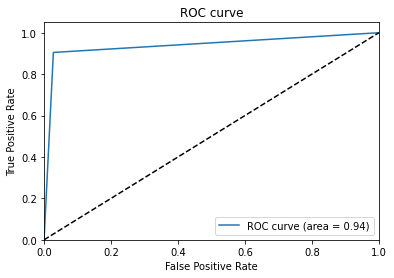

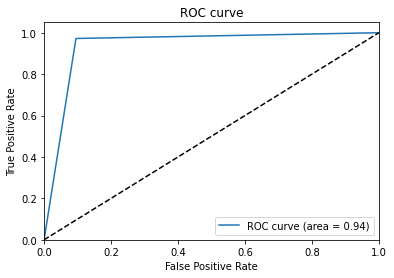

In [ ]:
import matplotlib.pyplot as plt

# Plot of a ROC curve for a specific class
for i in list(LANGUAGES_N.values()):
      plt.figure()
      plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC curve')
      plt.legend(loc="lower right")
      plt.show()